In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import spatial
from sklearn import preprocessing
import seaborn as sns; sns.set()
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import torch
from torch import nn
from torch.autograd import Variable

In [ ]:
# read in training set 
nielsen_validation=pd.read_csv('nielsen_pairs.csv')
raw_metrics_sim=[]
raw_metrics_dif=[]

#create features
num_rows=len(nielsen_validation)
num_cols=9

raw_metrics_sim=np.zeros((num_rows,num_cols))
raw_metrics_dif=np.zeros((num_rows,num_cols))

# features are created by using each of the 3 distance metrics across each pair of similar columns. 
#Mismatch and match refer to the training set types.  Match means that the two items are a known match and
#Mismatch means that the two items are a known mismatch.  Mismatch is useful for pairwise Loss functions.  Loss 
#can incentivise maximal string distance between matches and mismatches which is a convex function. 
for x in range (0,num_rows):
    p1=nielsen_validation['item_description_match'][x]
    p2=nielsen_validation['item_description_sgws'][x]
    p3=nielsen_validation['item_description_mismatch'][x]
    s1=nielsen_validation['supplier_match'][x]
    s2=nielsen_validation['supplier_sgws'][x]
    s3=nielsen_validation['supplier_mismatch'][x]
    b1=nielsen_validation['brand_match'][x]
    b2=nielsen_validation['brand_sgws'][x]
    b3=nielsen_validation['brand_mismatch'][x]

    f1=levenshtein_distance(p1,p2)
    f2=bag_of_letters(p1,p2)
    f3=levenshtein_distance_tokenize(p1,p2)
    f4=levenshtein_distance(s1,s2)
    f5=bag_of_letters(s1,s2)
    f6=levenshtein_distance_tokenize(s1,s2)
    f7=levenshtein_distance(b1,b2)
    f8=bag_of_letters(b1,b2)
    f9=levenshtein_distance_tokenize(b1,b2)
    
    f11=levenshtein_distance(p3,p2)
    f21=bag_of_letters(p3,p2)
    f31=levenshtein_distance_tokenize(p3,p2)
    f41=levenshtein_distance(s3,s2)
    f51=bag_of_letters(s3,s2)
    f61=levenshtein_distance_tokenize(s3,s2)
    f71=levenshtein_distance(b3,b2)
    f81=bag_of_letters(b3,b2)
    f91=levenshtein_distance_tokenize(b3,b2)
    
    raw_metrics_sim[x,:]=[f1,f2,f3,f4,f5,f6,f7,f8,f9]
    raw_metrics_dif[x,:]=[f11,f21,f31,f41,f51,f61,f71,f81,f91]


In [ ]:
#Creating Models

#first model is very simple.  Model is a linear model which tunes weights on features to minimize pairwise loss. Model
#achieved about a 70 percent match success rate on training set.  
raw_metrics_simv = Variable(torch.FloatTensor(raw_metrics_sim))
raw_metrics_difv = Variable(torch.FloatTensor(raw_metrics_dif))
lambd = 1.

w = Variable(torch.ones(raw_metrics_sim.shape[1]), requires_grad=True)
optimizer = torch.optim.SGD([w], lr=1e-3)

for _ in range(5):
    optimizer.zero_grad()
    l = loss(w, raw_metrics_difv, raw_metrics_simv)
    print (l.item())
    l.backward()
    optimizer.step()
    wnp = projection_simplex_sort(w.data.numpy())
    w.data = torch.Tensor(wnp)
    
#testing neural net model.  Net with ReLU and Sigmoid activation function. 
net = nn.Sequential(nn.Linear(9,32),nn.ReLU(),nn.Linear(32,1),nn.Sigmoid())

l = loss(net, raw_metrics_difv, raw_metrics_simv)
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)

for _ in range(20):
    optimizer.zero_grad()
    l = loss(net, raw_metrics_difv, raw_metrics_simv)
    print (l.item())
    l.backward()
    optimizer.step()

accuracy(net, nielsen_validation.head(100), "pytorch")

#create feature matrix to feed into SVM and Logestic Regression Models.
features=feature_matrix(1000)

#Logistic regression and svm model creation
log_reg,X_log,Y_log=logistic_regression_model(features)

#This is the model that I ended up using.  I simply just took this model out of this notebook 
#with the same weights and hyperperameters and ran it on the real set I needed to match items with.  
#I then ran the Hungarian method to pick top matches and created a table in our database to save the top matches
# as well as the top 5 matches in case the wrong product was selected.  
svm,X_train,Y_train=svm_model(features,"rbf")

In [31]:
#tokenizing words to remove word order bias from levenshtein distance, Output 0-1
def levenshtein_distance_tokenize(s_nielsen, s_sgws):
    if not isinstance(s_nielsen, str) or  not isinstance(s_sgws,str):
        return -1
    
    s1_set=s_nielsen.split(" ")
    s2_set=s_sgws.split(" ")
    
    current_distance=0
    distance_sum=0
    for sgws_word in s2_set:
        min_distance=1
        for nielsen_word in s1_set:
            current_distance= levenshtein_distance(sg​#tokenizing words to remove word order bias from levenshtein distance, Output 0-1
def levenshtein_distance_tokenize(s_nielsen, s_sgws):
    if not isinstance(s_nielsen, str) or  not isinstance(s_sgws,str):
        return -1
    
    s1_set=s_nielsen.split(" ")
    s2_set=s_sgws.split(" ")
    
    current_distance=0
    distance_sum=0
    for sgws_word in s2_set:
        min_distance=1
        for nielsen_word in s1_set:
            current_distance= levenshtein_distance(sgws_word,nielsen_word)
            if current_distance <= min_distance:
                min_distance=current_distance
                
        distance_sum+=min_distance
    distance_sum=distance_sum/len(s2_set)
    return distance_sum

#Edit Distance. Credit to user Salvador Dali on Stack Overflow. I modified range of output to be between 0 and 1 by 
#dividing by max edit distance.
def levenshtein_distance(s1, s2):

    if not isinstance(s1, str) or  not isinstance(s2,str):
        return 1
    
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]*1.0/max(len(s1),len(s2))

#A similarity ratio.  Output 0-1
def bag_of_letters(s_nielsen,s_sgws):
    if not isinstance(s_nielsen, str) or  not isinstance(s_sgws,str):
        return 1
    match_count=0.0
    for char in s_sgws:
        if char in s_nielsen:
            match_count+=1
            s_nielsen.replace(char,"",1)
    #added in nielsen_length penalty
    return(1-match_count/len(s_sgws))

#Pairwise loss for pytorch
def loss(w, raw_metrics_dif, raw_metrics_sim):
    loss = 0.
    N = raw_metrics_dif.shape[0]
    for i in range(N):
        loss += w.dot(raw_metrics_sim[i])**2 / N
        loss -= lambd * w.dot(raw_metrics_dif[i])**2 / N
    return loss

def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


#Testing some loss functions.  To save time I tried many different loss functions by modifying this 
#procedure and used numerical gradient descent to quickly test the quality of the loss function.  
def Loss_Testing(feature_matrix,weights):
    num_rows=len(feature_matrix)
    loss_matrix=np.zeros((num_rows,num_rows))
    diagonal=[]
    non_diagonal=[]
    for x in range(0,num_rows):
        for y in range(0,num_rows):
            loss_matrix[x,y]=np.dot(weights,feature_matrix[x,y])
            if x==y:
                diagonal.append(np.dot(weights,feature_matrix[x,y]))
            else:
                non_diagonal.append(np.dot(weights,feature_matrix[x,y]))
    
    diagonal_loss = sum(diagonal)/len(diagonal)
    non_diagonal_loss = sum(non_diagonal)/len(non_diagonal)    
    loss=diagonal_loss + abs((5-non_diagonal_loss))
                                      
    return loss_matrix,non_diagonal_loss,diagonal_loss,loss

#Rather then generate features over and over again, a feature matrix can be saved in memory for quick and 
#easy use.  The feature matrix comes in handy for testing Loss functions and accuracy quickly.  
def feature_matrix(num_rows,nielsen_validation=nielsen_validation):
    feature_matrix=np.zeros((num_rows,num_rows,9))
    
    for x in range (0,num_rows):
        prod=nielsen_validation['item_description_sgws'][x]
        sup=nielsen_validation['supplier_sgws'][x]
        brand=nielsen_validation['brand_sgws'][x]
        size = nielsen_validation['size_sgws'][x]
        
        for y in range (0,num_rows):
            #if nielsen_validation['size_match'][y] == size:
            n_prod=nielsen_validation['item_description_match'][y]
            n_sup=nielsen_validation['supplier_match'][y]
            n_brand=nielsen_validation['brand_match'][y]

            f1=levenshtein_distance(prod,n_prod)
            f2=bag_of_letters(prod,n_prod)
            f3=levenshtein_distance_tokenize(prod,n_prod)
            f4=levenshtein_distance(sup,n_sup)
            f5=bag_of_letters(sup,n_sup)
            f6=levenshtein_distance_tokenize(sup,n_sup)
            f7=levenshtein_distance(brand,n_brand)
            f8=bag_of_letters(brand,n_brand)
            f9=levenshtein_distance_tokenize(brand,n_brand)

            features=np.array([f1,f2,f3,f4,f5,f6,f7,f8,f9])
            #else:
                #features=np.ones(9)

            feature_matrix[x,y,:]=features
    return feature_matrix

#Test the accuracy of a model over the feature matrix
def accuracy_feature_matrix(model,samples=feature_matrix):
    count=0.0
    for x in range (0,len(samples)):
        match_row=0
        min_distance=100
        for y in range (0,len(samples)):
            
            features=samples[x,y,:]
            distance= model.predict_proba([features])[0][0]

            if distance <= min_distance:
                min_distance=distance
                match_row = y
                
        if match_row == x:
            count=count+1.0
    return count/len(samples)

    
#Support vector machine using Sklearn.  This was the best performing classifier with 90% accuracy.
def svm_model(features,kernel_type="rbf"):
    from sklearn import svm
    #structure in the form X,Y
    num_rows=len(features)
    X=np.zeros((num_rows**2,9))
    Y=np.zeros((num_rows**2))
    count=0
    for x in range(0,num_rows):
        for y in range(0,num_rows):
            X[count,:]=features[x,y,:]
            if x!=y:
                Y[count]=0
            else:
                Y[count]=1
            count+=1
    X=preprocessing.scale(X)
    model=svm.SVC(probability=True,kernel=kernel_type)
    model.fit(X, Y)
    
    return model,X,Y
    def svm_accuracy(model,X,Y):
    num_rows = len(Y)
    root_rows=int(num_rows**.5)
    count=0.0
    for x in range (0,root_rows):
        match_row=0
        min_distance=100
        size= nielsen_validation['size_match'][x]
        for y in range (0,root_rows):
            if nielsen_validation['size_match'][y] == size:
                features=X[x*root_rows+y]
                distance= model.predict_proba([features])[0][0]

                if distance <= min_distance:
                    min_distance=distance
                    match_row = y
        if match_row == x:
            count=count+1.0
    return count/root_rows

#test the accuracy of a model on raw input data.  Only useful for models trained on raw.  Cannot take in feature matrix
def accuracy_raw_data(model,samples=nielsen_validation,model_type="sklearn"):
    count=0.0
    for x in range (0,len(samples)):
        prod=nielsen_validation['item_description_sgws'][x]
        sup=nielsen_validation['supplier_sgws'][x]
        brand=nielsen_validation['brand_sgws'][x]
        size = nielsen_validation['size_sgws'][x]
        
        match_row=0
        min_distance=100
        for y in range (0,len(samples)):
            if nielsen_validation['size_match'][y] == size:
                n_prod=nielsen_validation['item_description_match'][y]
                n_sup=nielsen_validation['supplier_match'][y]
                n_brand=nielsen_validation['brand_match'][y]

                f1=levenshtein_distance(prod,n_prod)
                f2=bag_of_letters(prod,n_prod)
                f3=levenshtein_distance_tokenize(prod,n_prod)
                f4=levenshtein_distance(sup,n_sup)
                f5=bag_of_letters(sup,n_sup)
                f6=levenshtein_distance_tokenize(sup,n_sup)
                f7=levenshtein_distance(brand,n_brand)
                f8=bag_of_letters(brand,n_brand)
                f9=levenshtein_distance_tokenize(brand,n_brand)

                features=np.array([f1,f2,f3,f4,f5,f6,f7,f8,f9])
                if model_type=="scaler":
                    distance= np.dot(model,features)
                elif model_type == 'pytorch':
                    distance = model(Variable(torch.Tensor(features).unsqueeze(0))).item()
                else:
                    distance= model.predict_proba([features])[0][0]

                if distance <= min_distance:
                    min_distance=distance
                    match_row = y
                
        if match_row == x:
            count=count+1.0
    return count/len(samples)

#useful function for compressing ouput.  
def sigmoid(v):
    if isinstance(v,float):
        return 1 / (1 + math.exp(-v))
    vector=np.zeros(len(v))
    for x in range (0,len(v)):
        vector[x]= 1 / (1 + math.exp(-v[x]))
    return vector

#Numeric gradient descent implimentation for linear models.  Useful for testing different loss functions 
#without having to differentiate.  
def numeric_gradient_descent(features,learn_rate,step_size,iterations):
    w=np.random.rand(9)
    for k in range(0,iterations):
        gradient=np.zeros(9)
        current_loss=(Loss(features,w))[3]
        print(current_loss)
        for f in range (0,9):
            w_dif=w
            w_dif[f]=w_dif[f]+step_size
            new_loss=(Loss(features,w_dif))[3]
            current_gradient=(new_loss-current_loss)/step_size
            gradient[f]=current_gradient*-1
    w=w+gradient*learn_rate
    return w

#Tried logistic regression.  Performed close to linear weight optimization models.  
def logistic_regression_model(features):
    #structure in the form X,Y
    num_rows=len(features)
    X=np.zeros((num_rows**2,9))
    Y=np.zeros((num_rows**2))
    count=0
    for x in range(0,num_rows):
        for y in range(0,num_rows):
            X[count,:]=features[x,y,:]
            if x!=y:
                Y[count]=0
            else:
                Y[count]=1
            count+=1
    X=preprocessing.scale(X)
    model=LogisticRegression(solver = 'lbfgs')
    model.fit(X, Y)
    return model,X,Y
        
ws_word,nielsen_word)
            if current_distance <= min_distance:
                min_distance=current_distance
                
        distance_sum+=min_distance
    distance_sum=distance_sum/len(s2_set)
    return distance_sum

#Edit Distance. Credit to user Salvador Dali on Stack Overflow. I modified range of output to be between 0 and 1 by 
#dividing by max edit distance.
def levenshtein_distance(s1, s2):

    if not isinstance(s1, str) or  not isinstance(s2,str):
        return 1
    
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]*1.0/max(len(s1),len(s2))

#A similarity ratio.  Output 0-1
def bag_of_letters(s_nielsen,s_sgws):
    if not isinstance(s_nielsen, str) or  not isinstance(s_sgws,str):
        return 1
    match_count=0.0
    for char in s_sgws:
        if char in s_nielsen:
            match_count+=1
            s_nielsen.replace(char,"",1)
    #added in nielsen_length penalty
    return(1-match_count/len(s_sgws))

#Pairwise loss for pytorch
def loss(w, raw_metrics_dif, raw_metrics_sim):
    loss = 0.
    N = raw_metrics_dif.shape[0]
    for i in range(N):
        loss += w.dot(raw_metrics_sim[i])**2 / N
        loss -= lambd * w.dot(raw_metrics_dif[i])**2 / N
    return loss

def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


#Testing some loss functions.  To save time I tried many different loss functions by modifying this 
#procedure and used numerical gradient descent to quickly test the quality of the loss function.  
def Loss_Testing(feature_matrix,weights):
    num_rows=len(feature_matrix)
    loss_matrix=np.zeros((num_rows,num_rows))
    diagonal=[]
    non_diagonal=[]
    for x in range(0,num_rows):
        for y in range(0,num_rows):
            loss_matrix[x,y]=np.dot(weights,feature_matrix[x,y])
            if x==y:
                diagonal.append(np.dot(weights,feature_matrix[x,y]))
            else:
                non_diagonal.append(np.dot(weights,feature_matrix[x,y]))
    
    diagonal_loss = sum(diagonal)/len(diagonal)
    non_diagonal_loss = sum(non_diagonal)/len(non_diagonal)    
    loss=diagonal_loss + abs((5-non_diagonal_loss))
                                      
    return loss_matrix,non_diagonal_loss,diagonal_loss,loss

#Rather then generate features over and over again, a feature matrix can be saved in memory for quick and 
#easy use.  The feature matrix comes in handy for testing Loss functions and accuracy quickly.  
def feature_matrix(num_rows,nielsen_validation=nielsen_validation):
    feature_matrix=np.zeros((num_rows,num_rows,9))
    
    for x in range (0,num_rows):
        prod=nielsen_validation['item_description_sgws'][x]
        sup=nielsen_validation['supplier_sgws'][x]
        brand=nielsen_validation['brand_sgws'][x]
        size = nielsen_validation['size_sgws'][x]
        
        for y in range (0,num_rows):
            #if nielsen_validation['size_match'][y] == size:
            n_prod=nielsen_validation['item_description_match'][y]
            n_sup=nielsen_validation['supplier_match'][y]
            n_brand=nielsen_validation['brand_match'][y]

            f1=levenshtein_distance(prod,n_prod)
            f2=bag_of_letters(prod,n_prod)
            f3=levenshtein_distance_tokenize(prod,n_prod)
            f4=levenshtein_distance(sup,n_sup)
            f5=bag_of_letters(sup,n_sup)
            f6=levenshtein_distance_tokenize(sup,n_sup)
            f7=levenshtein_distance(brand,n_brand)
            f8=bag_of_letters(brand,n_brand)
            f9=levenshtein_distance_tokenize(brand,n_brand)

            features=np.array([f1,f2,f3,f4,f5,f6,f7,f8,f9])
            #else:
                #features=np.ones(9)

            feature_matrix[x,y,:]=features
    return feature_matrix

#Test the accuracy of a model over the feature matrix
def accuracy_feature_matrix(model,samples=feature_matrix):
    count=0.0
    for x in range (0,len(samples)):
        match_row=0
        min_distance=100
        for y in range (0,len(samples)):
            
            features=samples[x,y,:]
            distance= model.predict_proba([features])[0][0]

            if distance <= min_distance:
                min_distance=distance
                match_row = y
                
        if match_row == x:
            count=count+1.0
    return count/len(samples)

    
#Support vector machine using Sklearn.  This was the best performing classifier with 90% accuracy.
def svm_model(features,kernel_type="rbf"):
    from sklearn import svm
    #structure in the form X,Y
    num_rows=len(features)
    X=np.zeros((num_rows**2,9))
    Y=np.zeros((num_rows**2))
    count=0
    for x in range(0,num_rows):
        for y in range(0,num_rows):
            X[count,:]=features[x,y,:]
            if x!=y:
                Y[count]=0
            else:
                Y[count]=1
            count+=1
    X=preprocessing.scale(X)
    model=svm.SVC(probability=True,kernel=kernel_type)
    model.fit(X, Y)
    
    return model,X,Y
    def svm_accuracy(model,X,Y):
    num_rows = len(Y)
    root_rows=int(num_rows**.5)
    count=0.0
    for x in range (0,root_rows):
        match_row=0
        min_distance=100
        size= nielsen_validation['size_match'][x]
        for y in range (0,root_rows):
            if nielsen_validation['size_match'][y] == size:
                features=X[x*root_rows+y]
                distance= model.predict_proba([features])[0][0]

                if distance <= min_distance:
                    min_distance=distance
                    match_row = y
        if match_row == x:
            count=count+1.0
    return count/root_rows

#test the accuracy of a model on raw input data.  Only useful for models trained on raw.  Cannot take in feature matrix
def accuracy_raw_data(model,samples=nielsen_validation,model_type="sklearn"):
    count=0.0
    for x in range (0,len(samples)):
        prod=nielsen_validation['item_description_sgws'][x]
        sup=nielsen_validation['supplier_sgws'][x]
        brand=nielsen_validation['brand_sgws'][x]
        size = nielsen_validation['size_sgws'][x]
        
        match_row=0
        min_distance=100
        for y in range (0,len(samples)):
            if nielsen_validation['size_match'][y] == size:
                n_prod=nielsen_validation['item_description_match'][y]
                n_sup=nielsen_validation['supplier_match'][y]
                n_brand=nielsen_validation['brand_match'][y]

                f1=levenshtein_distance(prod,n_prod)
                f2=bag_of_letters(prod,n_prod)
                f3=levenshtein_distance_tokenize(prod,n_prod)
                f4=levenshtein_distance(sup,n_sup)
                f5=bag_of_letters(sup,n_sup)
                f6=levenshtein_distance_tokenize(sup,n_sup)
                f7=levenshtein_distance(brand,n_brand)
                f8=bag_of_letters(brand,n_brand)
                f9=levenshtein_distance_tokenize(brand,n_brand)

                features=np.array([f1,f2,f3,f4,f5,f6,f7,f8,f9])
                if model_type=="scaler":
                    distance= np.dot(model,features)
                elif model_type == 'pytorch':
                    distance = model(Variable(torch.Tensor(features).unsqueeze(0))).item()
                else:
                    distance= model.predict_proba([features])[0][0]

                if distance <= min_distance:
                    min_distance=distance
                    match_row = y
                
        if match_row == x:
            count=count+1.0
    return count/len(samples)

#useful function for compressing ouput.  
def sigmoid(v):
    if isinstance(v,float):
        return 1 / (1 + math.exp(-v))
    vector=np.zeros(len(v))
    for x in range (0,len(v)):
        vector[x]= 1 / (1 + math.exp(-v[x]))
    return vector

#Numeric gradient descent implimentation for linear models.  Useful for testing different loss functions 
#without having to differentiate.  
def numeric_gradient_descent(features,learn_rate,step_size,iterations):
    w=np.random.rand(9)
    for k in range(0,iterations):
        gradient=np.zeros(9)
        current_loss=(Loss(features,w))[3]
        print(current_loss)
        for f in range (0,9):
            w_dif=w
            w_dif[f]=w_dif[f]+step_size
            new_loss=(Loss(features,w_dif))[3]
            current_gradient=(new_loss-current_loss)/step_size
            gradient[f]=current_gradient*-1
    w=w+gradient*learn_rate
    return w

#Tried logistic regression.  Performed close to linear weight optimization models.  
def logistic_regression_model(features):
    #structure in the form X,Y
    num_rows=len(features)
    X=np.zeros((num_rows**2,9))
    Y=np.zeros((num_rows**2))
    count=0
    for x in range(0,num_rows):
        for y in range(0,num_rows):
            X[count,:]=features[x,y,:]
            if x!=y:
                Y[count]=0
            else:
                Y[count]=1
            count+=1
    X=preprocessing.scale(X)
    model=LogisticRegression(solver = 'lbfgs')
    model.fit(X, Y)
    return model,X,Y

(4.9890987903696864, 0.6263310781736513, 0.4031918291164821)


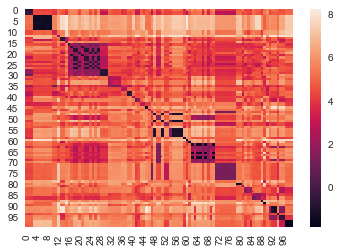

In [1669]:
#visualized some matches (diagonal) and nonmatches (everything else) in the eyes of the algorithm.  
loss_map,d_loss,s_loss,loss=Loss(features,w)
print(d_loss,s_loss, loss)
ax = sns.heatmap(loss_map[0:100,0:100])
plt.show()